In [8]:
!pip3 install retentioneering

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


  Attempting uninstall: six
    Found existing installation: six 1.10.0
    Uninstalling six-1.10.0:
      Successfully uninstalled six-1.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cbpro 1.1.4 requires six==1.10.0, but you have six 1.16.0 which is incompatible.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [10]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import retentioneering
import numpy as np
import os,sys,inspect
import datetime
from copy import deepcopy, copy
from calendar import monthrange
from tqdm.auto import tqdm, trange
import scipy.stats as st
import matplotlib.pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
import warnings
import seaborn as sns; sns.set_style('whitegrid')
import matplotlib.gridspec as gridspec
import re
from copy import deepcopy
import time
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr as pearson_test
from sklearn.cluster import KMeans
from collections import Counter
from IPython.display import clear_output
import networkx as nx

#Special magic to import a module from parent directory
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

def cut_conversion(data,target_event,keep_target=False):
    data_cut = data.copy()
    data_cut['was_conversion'] = 0
    data_cut.loc[data_cut.event==target_event,'was_conversion'] = 1
    data_cut['was_conversion'] = data_cut.groupby('client_id').was_conversion.cumsum()
    if keep_target:
        data_cut.loc[data_cut.event==target_event,'was_conversion'] = 0
    data_cut = data_cut[data_cut.was_conversion == 0]

    data_cut['dist_to_target'] = np.inf
    mask = data_cut.client_id.isin(data_cut[data_cut.event==target_event].client_id.unique())
    data_cut.loc[mask,'dist_to_target'] = data_cut.loc[mask].groupby('client_id').dist_to_target.cumcount(ascending=False)
    data_cut.sort_values('global_idx',inplace=True)
    return data_cut

def link_corpus_cjm(corpus):
    corpus = corpus.reset_index()
    corpus.event = corpus.event.apply(lambda x: '~~'.join([el.lower() for el in x]))
    return corpus

def prepare_for_clustering(session_corpus, col='session', ngram_range=(1,1), flag_session_list=[],flags_enumerate=[],insert_flags=False):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, token_pattern='[^~]+').fit(session_corpus.event)
    vocab_with_flags = vectorizer.vocabulary_
    if insert_flags:
        flags = [f'flag_{x}' for x in flags_enumerate.keys()]
        vocab_with_flags.update({flag: ind for ind, flag in enumerate(flags)})
        vocab_with_flags = {val: ind for ind, val in enumerate(vocab_with_flags.keys())}
        # Appending flags to sessions
        for key, val in flag_session_list.items():
            session_corpus.loc[session_corpus[col].isin(val), 'event'] = \
                session_corpus.loc[session_corpus[col].isin(val), 'event'].apply(lambda x: x + f'~~flag_{key}')

    vectorizer = TfidfVectorizer(vocabulary=vocab_with_flags,
                                 token_pattern='[^~]+')
    tfidf = pd.DataFrame(index=session_corpus[col].values,
                         data=vectorizer.fit_transform(session_corpus.event).todense())
    tfidf.columns = vectorizer.get_feature_names()
    return tfidf

normalize = lambda x: x / sum(x)

%matplotlib inline

# Изучение данных

In [31]:
import IPython
import io

res = pd.read_csv('test_data_rete.csv')

res.head()
res['event'].value_counts()

/catalog                    81357
/cart                        5495
/main                        3902
/search                      3882
buyButton                    3795
click_goToCart               2867
Checkout_PaymentDelivery     2855
global_lost                  2349
CheckoutInstallment          1354
click_Product                1054
purchase                      703
click_buyButton               519
Refund                          1
Name: event, dtype: int64

Наши данные уже предобработаны, отсортированы по клиентам и их сессиям

In [11]:
retentioneering.config.update({
    'experiments_folder': 'experiments',
    'user_col': 'client_id',
    'event_col':'event',
    'event_time_col':'timestamp',
})

# res_rete = res.retention.prepare().sort_values(['client_id','timestamp'])
# res_rete['next_event'] = \
#         res_rete.groupby('session').event.shift(-1).fillna('end_of_session')
# res_rete['global_idx'] = np.arange(res_rete.shape[0])
# res_rete['client_idx'] = res_rete.groupby('client_id').cumcount()


# Predicting conversion

In [15]:
res_rete = res
print(f"Mean session length: {round(res_rete.groupby('client_id').event.count().mean())}")

Mean session length: 40


Как и в примере из лекции среднее количество переходов в сессии пользователя = 40  
  
Обрежем последние 20 ивентов

In [21]:
#Cut target_events
res_rete_cut = cut_conversion(res_rete.sort_values(['client_id','timestamp']),'purchase')
idx_dict = res_rete_cut.groupby('client_id').client_idx.max().to_dict()
res_rete_cut['max_idx'] = (res_rete_cut.client_id.map(idx_dict) - 20).apply(lambda x: x if x > 0 else 0)
selected = res_rete_cut[res_rete_cut.max_idx > 0]
#Cut last 20 events
selected = selected[(selected.client_idx <= selected.max_idx)]
print(f"Fraction of users with session length >= 20: {selected.client_id.nunique()/res_rete_cut.client_id.nunique()}")

Fraction of users with session length >= 20: 0.9323984178353111


In [24]:
selected

,client_id,session,timestamp,event,next_event,global_idx,client_idx,was_conversion,dist_to_target,max_idx
0,100387706708393501,1003877067083935011579908637,2020-01-24 23:30:37,/catalog,/catalog,0,0,0,inf,7
1,100387706708393501,1003877067083935011579908637,2020-01-26 08:12:40,/catalog,/catalog,1,1,0,inf,7
2,100387706708393501,1003877067083935011579908637,2020-01-26 10:53:29,/catalog,/catalog,2,2,0,inf,7
3,100387706708393501,1003877067083935011579908637,2020-01-26 11:49:41,/catalog,/catalog,3,3,0,inf,7
4,100387706708393501,1003877067083935011579908637,2020-01-27 01:06:18,/catalog,/catalog,4,4,0,inf,7
...,...,...,...,...,...,...,...,...,...,...
110108,9995026857664617766,99950268576646177661580059524,2020-01-26 17:25:24,/catalog,end_of_session,110108,2,0,inf,6
110109,9995026857664617766,99950268576646177661580034406,2020-01-26 20:45:31,/catalog,/catalog,110109,3,0,inf,6
110110,9995026857664617766,99950268576646177661580034406,2020-01-26 22:34:05,/catalog,/catalog,110110,4,0,inf,6
110111,9995026857664617766,99950268576646177661580034406,2020-01-27 03:55:02,/catalog,/catalog,110111,5,0,inf,6


In [22]:
#Sanity check - last 20 events are cut
res_rete[res_rete.client_id==100387706708393501].client_idx.max() - \
    selected[selected.client_id==100387706708393501].client_idx.max()

20

Мы действительно обрезали последние 20 ивентов

In [23]:
#No target events are in data
selected[selected.event.isin(['global_lost','purchase'])].shape

(0, 10)

Размечаем пользователей на хороших и плохих

In [25]:
#Mapping users

good_users = res_rete[res_rete.event=='purchase'].client_id.unique()
bad_users = res_rete[~res_rete.client_id.isin(good_users)].client_id.unique()

In [28]:
# Для каждого юзера прописываем его движения в рамках сессии в виде списка
client_corpus = selected.groupby('client_id')['event'].apply(
        lambda x: np.array([l.lower() for l in x]))

# Преобразуем список в строку где ~~ используются как разделитель между ивентами
linked_client_corpus = link_corpus_cjm(client_corpus)

tfidf_clustering = prepare_for_clustering(linked_client_corpus.copy(),col='client_id',insert_flags=False)
tfidf_clustering
# X = tfidf_clustering
# y = [1 if t else 0 for t in tfidf_clustering.index.isin(good_users)]

,/cart,/catalog,/main,/search,buybutton,checkout_paymentdelivery,checkoutinstallment,click_buybutton,click_gotocart,click_product
640282419644438,0.139794,0.578377,0.594298,0.000000,0.413571,0.0,0.196496,0.0,0.155458,0.242752
4529886389034039,0.000000,0.995505,0.094714,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6198979391560121,0.000000,0.919290,0.393581,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
12542920991014397,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
13302576144359073,0.292595,0.726341,0.621946,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
17853323262601477878,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
17888585564621998201,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
17957828185246314183,0.000000,0.504253,0.863556,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
18060407767650607976,0.464139,0.153625,0.131544,0.752973,0.366166,0.0,0.000000,0.0,0.206458,0.000000


# Clustering

## After data cut

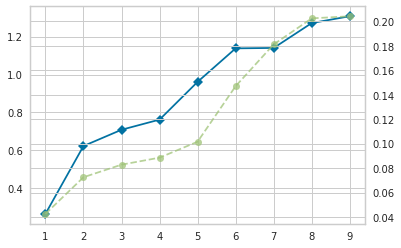

In [38]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(
    KMeans(random_state=42), k=(1,10),locate_elbow=True
)
good_val = visualizer.fit(tfidf_clustering)

array([3, 0, 0, ..., 3, 2, 0], dtype=int32)

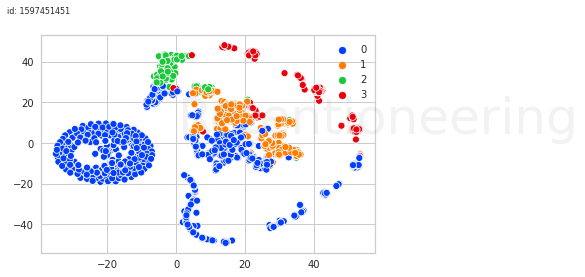

In [39]:
selected.retention.get_clusters(n_clusters=4,plot_type='cluster_tsne')

## Before data cut

In [40]:
full_client_corpus = res_rete.groupby('client_id')['event'].apply(
        lambda x: np.array([l.lower() for l in x]))

full_linked_client_corpus = link_corpus_cjm(full_client_corpus)
full_tfidf = prepare_for_clustering(full_linked_client_corpus.copy(),col='client_id',insert_flags=False)

CPU times: user 1.78 s, sys: 1.29 s, total: 3.07 s
Wall time: 1.56 s


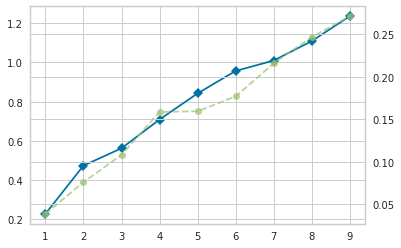

In [41]:
%%time
visualizer = KElbowVisualizer(
    KMeans(random_state=42), k=(1,10),locate_elbow=True
)
good_val = visualizer.fit(full_tfidf)

array([2, 0, 0, ..., 0, 1, 0], dtype=int32)

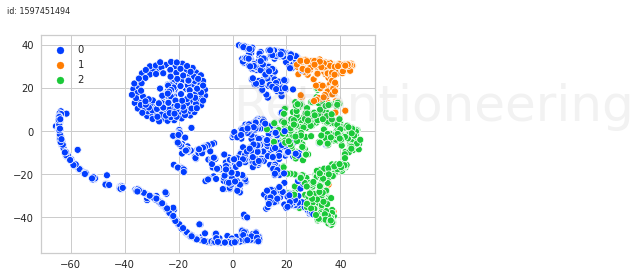

In [42]:
res_rete.retention.get_clusters(n_clusters=3,plot_type='cluster_tsne')

,0,1
640282419644438,34.065861,-31.221521
4529886389034039,-64.653023,0.330599
6198979391560121,21.281260,29.906694
12542920991014397,-26.874205,19.703747
13302576144359073,2.819021,-28.507664
...,...,...
17853323262601477878,-23.517170,18.228285
17888585564621998201,-24.021271,17.355042
17957828185246314183,-35.269665,-28.101734
18060407767650607976,37.989223,18.435543


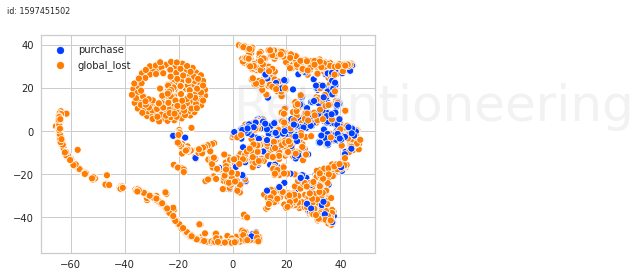

In [43]:
res_rete.retention.project(plot_type='targets')

# Some predictions here

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import roc_auc_score
lr = LogisticRegression()
rf = RandomForestClassifier(random_state=42,n_estimators=500)
ada = AdaBoostClassifier(n_estimators=100)


In [ ]:
cross_val_score(lr,X,y,scoring='accuracy').mean()

0.905900863704332

In [46]:
y

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [47]:
cross_val_score(lr,X,y,scoring='roc_auc').mean()

0.6883766548514793

In [48]:
cross_val_score(rf,X,y,scoring='accuracy').mean()

0.8931744295906145

In [49]:
cross_val_score(rf,X,y,scoring='roc_auc').mean()

0.6350938157438722

In [ ]:
cross_val_score(ada,X,y,scoring='accuracy').mean()

0.8935649935649936

In [ ]:
cross_val_score(ada,X,y,scoring='roc_auc').mean()

0.5898488029812479